References:
- <https://www.reneshbedre.com/blog/anova.html>

In [18]:
import numpy as np
import pandas as pd
from scipy.stats import f, f_oneway
import matplotlib.pyplot as plt
import seaborn as sns


# One-way ANOVA

See the problem here: <https://stattrek.com/anova/completely-randomized/one-way-example.aspx?tutorial=anova>

In [45]:
report = np.array([[210,   210,   180],
[240,   240,   210],
[270,   240,   210],
[270,   270,   210],
[300,   270,   240]])

##  Manually solving by using formula

In [24]:
nobs = report.size
n_groups = report.shape[1]
group_mean = report.mean(0)

In [25]:
grand_mean = np.mean(report)
grand_mean

238.0

In [26]:
# Sum of Squares total
SST = np.square(report - grand_mean).sum()
SST

15240.0

In [32]:
# Sum of Squares between
SSB = np.square(group_mean - grand_mean).sum() * report.shape[0]
SSB

6240.0

In [33]:
# Sum of Squares within
SSW = np.square(report - group_mean).sum() 
SSW

9000.0

In [34]:
# df of SSW
df_w = nobs - n_groups
# df of SSB
df_b = n_groups - 1

In [35]:
# between group mean square
MSB = SSB / df_b
MSB

3120.0

In [36]:
# within group mean square
MSW = SSW / df_w
MSW

750.0

In [37]:
# F ratio
F = MSB / MSW
F

4.16

In [39]:
# p-value
p_value = 1 - f.cdf(F, df_b, df_w)
p_value

0.0424175181764751

Since the P-value (0.04) in our experiment is smaller than the significance level (0.05), we reject the null hypothesis that drug dosage had no effect on cholesterol level. And we conclude that the mean cholesterol level in at least one treatment group differed significantly from the mean cholesterol level in another group.

In [41]:
# measure of effect size (exactly like R-squared)
eta = SSB / SST
eta

0.4094488188976378

41% variance of the dependent variable(cholesterol level) can be explained by the variance of the independent variable(dosage level)

## Solve by using tools

In [46]:
from scipy.stats import f_oneway

In [47]:
?f_oneway

Signature: f_oneway(*args, axis=0)
Docstring:
Perform one-way ANOVA.

The one-way ANOVA tests the null hypothesis that two or more groups have
the same population mean.  The test is applied to samples from two or
more groups, possibly with differing sizes.

Parameters
----------
sample1, sample2, ... : array_like
    The sample measurements for each group.  There must be at least
    two arguments.  If the arrays are multidimensional, then all the
    dimensions of the array must be the same except for `axis`.
axis : int, optional
    Axis of the input arrays along which the test is applied.
    Default is 0.

Returns
-------
statistic : float
    The computed F statistic of the test.
pvalue : float
    The associated p-value from the F distribution.

Warns
-----
F_onewayConstantInputWarning
    Raised if each of the input arrays is constant array.
    In this case the F statistic is either infinite or isn't defined,
    so ``np.inf`` or ``np.nan`` is returned.

F_onewayBadInputSizesWa

In [49]:
# f_oneway(group1_data, group2_data, group3_data, ...)
f_oneway(*np.transpose(report))

F_onewayResult(statistic=4.16, pvalue=0.04241751817647503)

## Applied ANOVA in python

In [82]:
df = pd.read_table('https://www.reneshbedre.com/assets/posts/anova/onewayanova.txt')
df

,A,B,C,D
0,25,45,30,54
1,30,55,29,60
2,28,29,33,51
3,36,56,37,62
4,29,40,27,73


In [83]:
# tidy data
data =df.melt(var_name = 'treatments')
data

,treatments,value
0,A,25
1,A,30
2,A,28
3,A,36
4,A,29
5,B,45
6,B,55
7,B,29
8,B,56
9,B,40


<AxesSubplot:xlabel='treatments', ylabel='value'>

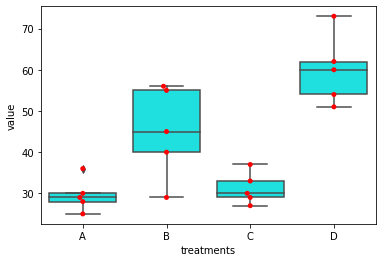

In [17]:
# use boxplot to see the data distribution by treatments
sns.boxplot(data = df, x = 'treatments', y = 'value', color = 'cyan')
sns.swarmplot(data = df, x = 'treatments', y = 'value', color = 'red')

In [22]:
f_oneway(df['A'], df['B'], df['C'], df['D'])

F_onewayResult(statistic=17.492810457516338, pvalue=2.639241146210922e-05)

In [30]:
# Get ANOVA like R input
from statsmodels.formula.api import ols
import statsmodels.api as sm

In [33]:
model = ols('value ~ C(treatments)', data = data).fit()
table = sm.stats.anova_lm(model, typ=2) # type 2 ANOVA
table

,sum_sq,df,F,PR(>F)
C(treatments),3010.95,3.0,17.49281,0.000026
Residual,918.00,16.0,NaN,NaN


**Conclusion**: The p-value is significant (p < 0.05). Therefore we conclude that there is a statistically significant differences among treatments.

### Post hoc Test

In [84]:
from bioinfokit.analys import stat
res = stat()
res.tukey_hsd(df=data, res_var='value', xfac_var='treatments', anova_model='value ~ C(treatments)')
res.tukey_summary

,group1,group2,Diff,Lower,Upper,q-value,p-value
0,A,B,15.4,1.692871,29.107129,4.546156,0.025070
1,A,C,1.6,-12.107129,15.307129,0.472328,0.900000
2,A,D,30.4,16.692871,44.107129,8.974231,0.001000
3,B,C,13.8,0.092871,27.507129,4.073828,0.048178
4,B,D,15.0,1.292871,28.707129,4.428074,0.029578
5,C,D,28.8,15.092871,42.507129,8.501903,0.001000


### Test ANOVA assumpsions

1. Normal assumption

In [59]:
# shapiro test, NULL hypothesis: sample are drawn from a normal distribution
from scipy.stats import shapiro
for col_name, column in df.iteritems():
    print(col_name, shapiro(column))

A ShapiroResult(statistic=0.9316344261169434, pvalue=0.6075581908226013)
B ShapiroResult(statistic=0.9264494776725769, pvalue=0.5723667740821838)
C ShapiroResult(statistic=0.9529604315757751, pvalue=0.7583119869232178)
D ShapiroResult(statistic=0.9448273181915283, pvalue=0.7002365589141846)


2. Independence

3. Equal Variance

In [61]:
from scipy.stats import bartlett, levene # read help to know which one to choose
# null hypothesis: equal variance
bartlett(df['A'], df['B'], df['C'], df['D'])

BartlettResult(statistic=5.687843565012841, pvalue=0.1278253399753447)

p_value < 0.05, fail to result the null hypothesis that the variance of each group is equal

In [62]:
levene(df['A'], df['B'], df['C'], df['D'])

LeveneResult(statistic=1.9219593192195938, pvalue=0.16673281219949276)

# Two-way ANOVA

## From scratch

In [5]:
shopping = np.array([
    75, 75, 90,
    70, 70, 70,
    50, 55, 75,
    65, 60, 85,
    80, 65, 80,
    65, 65, 65
])

shopping = pd.DataFrame(shopping.reshape((-1, 3)),
                        index=[f'Shopper {i}' for i in range(6)],
                        columns=['Sydney', 'New York', 'L.A'])
shopping

,Sydney,New York,L.A
Shopper 0,75,75,90
Shopper 1,70,70,70
Shopper 2,50,55,75
Shopper 3,65,60,85
Shopper 4,80,65,80
Shopper 5,65,65,65


In [6]:
n_obs = shopping.size
n_rows = shopping.shape[0]
n_cols = shopping.shape[1]

grand_mean = shopping.sum().sum() / n_obs

df_r = n_rows - 1
df_c = n_cols - 1
df_total = n_obs - 1
df_e = df_total - df_r - df_c  # equivalent df_r * df_c

SST = np.square(shopping - grand_mean).sum().sum()
SSR = np.square(shopping.mean(1) - grand_mean).mul(n_cols).sum()
SSC = np.square(shopping.mean(0) - grand_mean).mul(n_rows).sum()
SSE = SST - SSR - SSC

MST = SST / df_total
MSC = SSC / df_c
MSR = SSR / df_r
MSE = SSE / df_e


F_c = MSC / MSE
F_r = MSR / MSE

p_value_c = 1 - f.cdf(F_c, df_c, df_e)
p_value_r = 1 - f.cdf(F_r, df_r, df_e)

In [10]:
pd.DataFrame([
    [SST, df_total, MST, None,None],
    [SSR, df_r, MSR, F_r, p_value_r],
    [SSC, df_c, MSC, F_c, p_value_c],
    [SSE, df_e, MSE, None, None]
], 
columns = ['Sum of Squares', 'df', 'Mean Square', 'F', 'p_value'],
index = ['SST', 'SSR', 'SSC', 'SSE'])

,Sum of Squares,df,Mean Square,F,p_value
SST,1750.0,17,102.941176,NaN,NaN
SSR,750.0,5,150.000000,3.157895,0.057399
SSC,525.0,2,262.500000,5.526316,0.024181
SSE,475.0,10,47.500000,NaN,NaN


Confidence level 5%
P_value SSC < 5% so we have strong evidence against the null hypothesis that the mean of different cities are the same.

## Applied Two-way ANOVA in python

In [70]:
df = pd.read_csv('https://www.reneshbedre.com/assets/posts/anova/twowayanova.txt', sep = '\t')
df.head(10)

,Genotype,1_year,2_year,3_year
0,A,1.53,4.08,6.69
1,A,1.83,3.84,5.97
2,A,1.38,3.96,6.33
3,B,3.60,5.70,8.55
4,B,2.94,5.07,7.95
5,B,4.02,7.20,8.94
6,C,3.99,6.09,10.02
7,C,3.30,5.88,9.63
8,C,4.41,6.51,10.38
9,D,3.75,5.19,11.40


In [71]:
data = df.melt(id_vars = 'Genotype', value_vars = ['1_year', '2_year', '3_year'], var_name = 'year')
data.head(10)

,Genotype,year,value
0,A,1_year,1.53
1,A,1_year,1.83
2,A,1_year,1.38
3,B,1_year,3.60
4,B,1_year,2.94
5,B,1_year,4.02
6,C,1_year,3.99
7,C,1_year,3.30
8,C,1_year,4.41
9,D,1_year,3.75


In [72]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [73]:
model = ols('value ~ C(Genotype) + C(year) + C(Genotype)*C(year)', data = data).fit()

In [75]:
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(Genotype),58.551733,5.0,32.748581,1.931655e-12
C(year),278.925633,2.0,390.014868,4.006243e-25
C(Genotype):C(year),17.122967,10.0,4.788525,2.230094e-04
Residual,12.873000,36.0,NaN,NaN


**Interpretation**  
The p value obtained from ANOVA analysis for genotype, years, and interaction are statistically significant (p<0.05). We conclude that type of genotype significantly affects the yield outcome, time (years) significantly affects the yield outcome, and interaction of both genotype and time (years) significantly affects the yield outcome.

As the interaction is significant, let’s visualize the interaction plot (also called profile plot) for interaction effects,

<AxesSubplot:xlabel='Genotype', ylabel='value'>

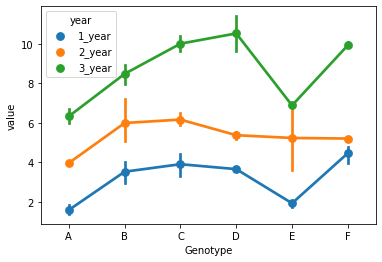

In [79]:
sns.pointplot(data = data, x = 'Genotype', y = 'value', hue = 'year')

From the interaction plot, the interaction effect is significant between the Genotype and years because three lines are not parallel (roughly parallel factor lines indicate no interaction - additive model). This interaction is also called ordinal interaction as the lines do not cross each other.

SyntaxError: invalid syntax (<ipython-input-81-50877b6c88ac>, line 1)